# Symbolic Regression with Genetic Programming

Date: 2021-01-11  
Categories: julia, evolutionary  
Tags: symbolic regression, genetic programming
<!--eofm-->

## Introduction

**Symbolic Regression** is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity. While conventional regression techniques seek to optimize the parameters for a pre-specified model structure, symbolic regression avoids imposing prior assumptions, and instead infers the model from the data. Common representation of the SR model is an expression tree.

- An example of the expression tree for $x^3+x^2+x$

![](Expression_Tree.png)

**Genetic Programming (GP)** evolves computer programs, traditionally represented as expression tree structures.  Some of the applications of GP are curve fitting, data modeling, symbolic regression, feature selection, classification, etc. 
<!--more-->

## Benchmark Function

We begin by importing some Julia libraries

In [1]:
using Evolutionary
using Random, StableRNGs
using Plots
Plots.gr()
default(fmt = :png)

We need to generate some data from **Nguyen-1** benchmark function: $x^3+x^2+x$

In [2]:
rng = StableRNG(42)
d, n = 1, 20
Nguyen1(x) = x*x*x + x*x + x
xs = sort!(2*rand(rng, n).-1)

20-element Vector{Float64}:
 -0.7792822569729165
 -0.6754297279613941
 -0.6580629014053798
 -0.6175170410836337
 -0.493789415420681
 -0.3557789733653576
 -0.11791281798995135
  0.16102972537039095
  0.19702890961130848
  0.254683337669654
  0.2751675124602033
  0.2867370641948148
  0.2926452861976534
  0.40955191116249523
  0.41764004846019365
  0.4786550558321383
  0.4868995797086484
  0.544767897566282
  0.6079438312231553
  0.9422669364129046

Next, we define collection of symbols and operations used for construction of of the genetic program expression.

First, we define the symbols

In [3]:
syms = [:x]

1-element Vector{Symbol}:
 :x

and, the allowed functions

In [4]:
funcs = Function[+, -, *, Evolutionary.aq] # aq is an analytic quotient: aq(x,y) = x/sqrt(1+y²)

4-element Vector{Function}:
 + (generic function with 308 methods)
 - (generic function with 314 methods)
 * (generic function with 506 methods)
 aq (generic function with 1 method)

Let's define the fitness function for evaluation of the genetic program as root-mean-square error (RMSE)

In [5]:
fitobj(expr) = sum( abs2.(Nguyen1.(xs) - Evolutionary.Expression(expr).(xs)) )/length(xs) |> sqrt

fitobj (generic function with 1 method)

Test some arbitrary expression with our fitness function

In [6]:
expr = Expr(:call, *, :x, :x)
println("Evaluate expression: ", Evolutionary.Expression(expr).(xs))
println("Obj. func = ", fitobj(expr))

Evaluate expression: [0.6072808360328027, 0.45620531741400283, 0.4330467822060666, 0.38132729602868615, 0.24382798678149786, 0.1265786778889078, 0.013903432646331393, 0.02593057245286353, 0.03882039122262117, 0.06486360248655501, 0.07571715991353616, 0.08221814398306135, 0.08564126353370646, 0.16773276793685238, 0.1744232100778329, 0.22911066247366743, 0.23707120072045845, 0.2967720622187871, 0.36959570192228836, 0.8878669794569608]
Obj. func = 0.7303370563815205


Now, we use `TreeGP` optimization  algorithm that will construct a symbolic solution for 

In [7]:
opts = Evolutionary.Options(rng = StableRNG(987498737423))

                  abstol = Inf
                  reltol = Inf
        successive_f_tol = 10
              iterations = 1000
             store_trace = false
              show_trace = false
              show_every = 1
                callback = nothing
              time_limit = NaN
         parallelization = serial
                     rng = StableRNGs.LehmerRNG(state=0x0000000000000000000001cbd705de1f)


In [8]:
res = Evolutionary.optimize(fitobj,
    TreeGP(50, Terminal[syms...], funcs,
        mindepth=1,
        maxdepth=4,
        selection = tournament(3),
        mutationRate = 0.05,
        crossoverRate = 0.9,
        simplify=Evolutionary.simplify!
    ),
    opts
)


 * Status: success

 * Candidate solution
    Minimizer:  (+)(x, (+)((*)(x, x), (*)(x, (*)(x, x))))
    Minimum:    0.0
    Iterations: 19

 * Found with
    Algorithm: TreeGP[P=50,Parameter[x],Function[-, *, Evolutionary.aq, +]]

 * Convergence measures
    |f(x) - f(x')| = 0.0 ≤ 1.0e-5

 * Work counters
    Seconds run:   0.8642 (vs limit Inf)
    Iterations:    19
    f(x) calls:    1000


We can generate minimizing expression in LaTeX format 

In [9]:
Evolutionary.minimizer(res) |> Evolutionary.Expression

(x+((x*x)+(x*(x*x))))

## Symbolic Regression

### Linear

We generate a dataset to work with

In [10]:
rng = StableRNG(42);
n = 50
xs = range(-20, 20, length=n) |> collect
ys = (rand(rng, n).*0.8.+0.3).*xs + (rand(rng, n).*5.0.+2.0)
xs, ys

([-20.0, -19.183673469387756, -18.367346938775512, -17.551020408163264, -16.73469387755102, -15.918367346938776, -15.10204081632653, -14.285714285714286, -13.46938775510204, -12.653061224489797  …  12.653061224489797, 13.46938775510204, 14.285714285714286, 15.10204081632653, 15.918367346938776, 16.73469387755102, 17.551020408163264, 18.367346938775512, 19.183673469387756, 20.0], [-11.2761206271005, -5.858362338299976, -14.21969894573035, -13.18143662851641, -4.3822993514616515, -7.481608044089917, -7.380678064815548, -7.114042119600957, -8.436135997590675, -4.204471051519161  …  12.627563419480886, 18.306318334129625, 17.740362112567237, 12.291075562742478, 19.787286653031906, 19.049239914198342, 22.004009242244763, 12.258773454958678, 25.889724817772922, 15.73817077392605])

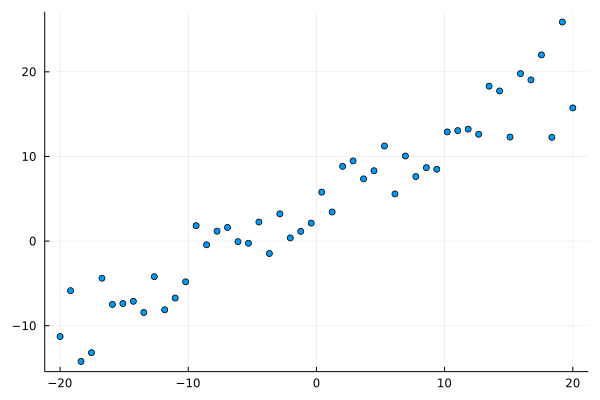

In [11]:
scatter(xs, ys, leg=:none)

Define our objective function and test it with an arbitrary exression

In [12]:
fitobj(expr) = sum( abs2.(ys - Evolutionary.Expression(expr).(xs)) ) |> sqrt

expr = Expr(:call, *, :x, :x)
println("Obj. func = ", fitobj(expr))

Obj. func = 1294.7548623203681


We need to the symbol collection `rand` function which will alow to generate numerical constanst in addition to the symbolical variables. For each symbol we specify its arity.

In [13]:
syms = Dict(:x=>1, (rand) => 1)

Dict{Any, Int64} with 2 entries:
  rand => 1
  :x   => 1

We define linear operations, and provide their arity.

In [14]:
funcs = Dict((+) => 2, (-) => 2,  (*) => 2, (Evolutionary.aq) => 2)

Dict{Function, Int64} with 4 entries:
  -  => 2
  *  => 2
  aq => 2
  +  => 2

We also need to increase maximum depth for the expression tree to accommodate more complex expressions

In [15]:
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 500,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=3,
        initialization=:full,
        selection = uniformranking(2),
        mutationRate = 0.1,
        crossoverRate = 0.95,        
        simplify=Evolutionary.simplify!        
    ),
    Evolutionary.Options(iterations=50, show_trace=true, show_every=10, rng=StableRNG(987498737423))
)

Iter     Function value
     0   26.980228209043624
 * time: 0.011682987213134766
    10   19.976831461385345
 * time: 1.2645831108093262



 * Status: success

 * Candidate solution
    Minimizer:  (+)((+)((-)(0.6834158734755182, x), (+)(x, 0.20154531730621472)), (+)((Evolutionary.aq)((+)(x, 0.20154531730621472), 0.8423178153097286), 3.32309880897011))
    Minimum:    19.976831461385345
    Iterations: 13

 * Found with
    Algorithm: TreeGP[P=500,Parameter[x],Function[-, *, Evolutionary.aq, +]]

 * Convergence measures
    |f(x) - f(x')| = 0.0 ≤ 1.0e-5

 * Work counters
    Seconds run:   1.6033 (vs limit Inf)
    Iterations:    13
    f(x) calls:    7000


Here is our minimizing expression

In [16]:
ex = Evolutionary.Expression(Evolutionary.minimizer(res))

(((0.683-x)+(x+0.202))+(aq((x+0.202), 0.842)+3.323))

Calculate least squares solution for comparison

In [17]:
X = hcat(ones(n), xs)
β = inv(X'X)*X'ys

2-element Vector{Float64}:
 4.361211389323667
 0.7782435754632802

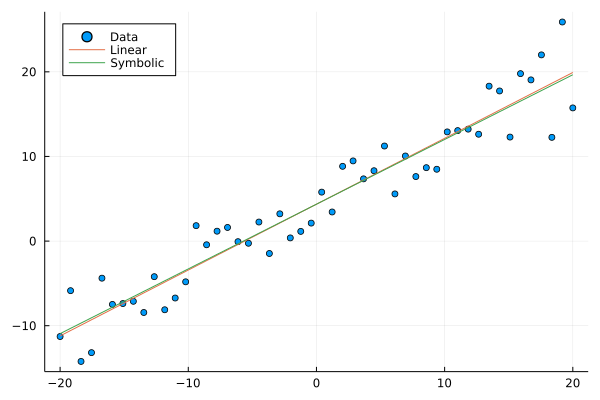

In [18]:
scatter(xs, ys, label="Data", legend=:topleft)
plot!(xs, β[2].*(xs).+β[1], label="Linear")
plot!(xs, ex.(xs), label="Symbolic")

### Nonlinear

Now, let's generate some noisy with nonlinear data

In [19]:
rng = StableRNG(42);
xs = collect(0:0.1:2*pi) |> sort!
ys = sin.(xs) + cos.(xs + xs) .+ randn(rng, length(xs))./2
xs, ys

([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2], [0.6648741539427164, 1.3034609157197612, 1.806545673789659, 1.775625569390072, 1.149160062560471, 1.3617018099706133, 0.41739900164343535, 0.4174284093198643, 1.5755188853166422, 1.2047978875432133  …  -0.2633485145419151, -0.9206622913615569, -1.0226097466209527, -0.05663518899024139, 0.20528055052971372, 0.14227439583858933, 0.3424355908688565, 0.3793396734383192, 1.1954801558035422, 0.374935723522007])

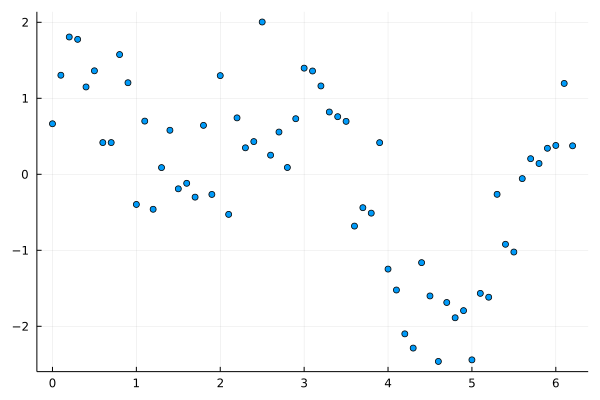

In [20]:
scatter(xs, ys, leg=:none)

We also expend the function collection with `sin`, `cos`, `log`,  and `exp`. We also provide arity for each function.

In [21]:
funcs = Dict((+) => 2, (-) => 2,  (*) => 2, (sin) => 1, (cos) => 1)
             #(^)=>2, (log) => 1, (exp) => 1)

Dict{Function, Int64} with 5 entries:
  -   => 2
  sin => 1
  cos => 1
  *   => 2
  +   => 2

We also need to increase maximum depth for the expression tree to accommodate more complex expressions

In [23]:
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 500,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=3,
        initialization=:grow,
        selection = uniformranking(2),
        mutationRate = 0.15,
        crossoverRate = 0.6,              
    ),
    Evolutionary.Options(iterations=60, show_trace=true, show_every=15, rng=StableRNG(987498737423))
)

Iter     Function value
     0   6.156961291594505
 * time: 6.198883056640625e-5
    15   6.056208796756655
 * time: 0.8294048309326172



 * Status: success

 * Candidate solution
    Minimizer:  (cos)((+)((*)(0.6668183013557487, x), (cos)(x)))
    Minimum:    6.056208796756655
    Iterations: 20

 * Found with
    Algorithm: TreeGP[P=500,Parameter[x],Function[-, sin, cos, *, +]]

 * Convergence measures
    |f(x) - f(x')| = 0.0 ≤ 1.0e-5

 * Work counters
    Seconds run:   1.1097 (vs limit Inf)
    Iterations:    20
    f(x) calls:    10500


Here is the resulting expression, and the plot of this expression evaluated on the original data.

- The resulting expression is very close to the original data-generating function, $\sin(x) + \cos(x + x) + \varepsilon$. 

In [24]:
ex = Evolutionary.Expression(Evolutionary.minimizer(res) |> copy)

cos(((0.667*x)+cos(x)))

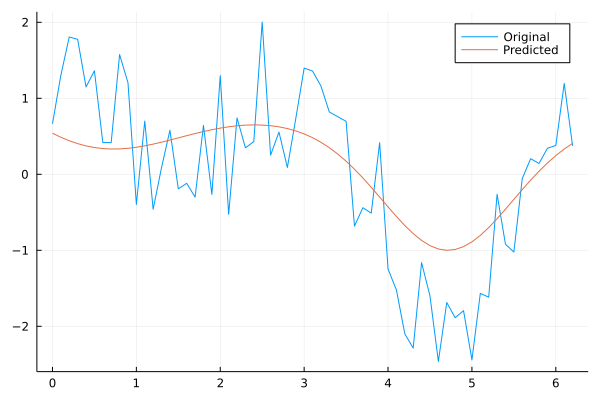

In [25]:
plot(xs, ys, label="Original")
plot!(xs, ex.(xs), label="Predicted")

### Expression Simplification 

However, sometimes, the generated expression can be quite long

In [43]:
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 500,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=3,
        initialization=:grow,    
        selection = tournament(3),
        mutationRate = 0.15,
        crossoverRate = 0.75,              
    ),
    Evolutionary.Options(iterations=35, show_trace=true, show_every=15, rng=StableRNG(987498737423))
)

Iter     Function value
     0   6.156961291594505
 * time: 6.198883056640625e-5
    15   4.125211174338502
 * time: 0.7877378463745117
    30   4.070365026676904
 * time: 3.570003032684326



 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer:  (+)((cos)((+)(x, x)), (-)((sin)((+)((*)((sin)((+)((cos)((cos)((+)((cos)((*)((*)(0.014687303588151845, (*)(0.21787006976551582, 0.1183292972139196)), 0.1183292972139196)), (*)(x, 0.1183292972139196)))), x)), (*)((cos)((+)(x, (*)(x, (*)((-)((+)(x, (*)((*)((cos)(x), (*)((*)(0.37197437782357445, (sin)((-)((sin)((+)((cos)((cos)((+)((-)((sin)((sin)(x)), 0.014687303588151845), 0.11816900245547068))), x)), 0.014687303588151845))), 0.1183292972139196)), x)), x), (+)(x, (+)(x, (*)((*)((cos)(x), (*)(0.21787006976551582, 0.1183292972139196)), 0.1183292972139196))))))), 0.1183292972139196)), (+)(0.11816900245547068, x))), 0.014687303588151845))
    Minimum:    4.038233331218614
    Iterations: 35

 * Found with
    Algorithm: TreeGP[P=500,Parameter[x],Function[-, sin, cos, *, +]]

 * Convergence measures
    |f(x) - f(x')| = 0.02937822042493199 ≰ 1.0e-5

 * Work counters
    Seconds run:   5.2194 (vs l

The minimizer function is quite long, so we might want to simplify it. We'll use `SymPy` package functionality to perform the expression simplification.

In [27]:
using SymPy, PyCall
sympycore = pyimport("sympy.core")

# Convert sympy expression back to the julia expression
function convert(::Type{Expr}, sexpr::Sym)
    # deal with numbers and symbols
    if sexpr.is_Float
        return Float64(sexpr.num)
    elseif sexpr.is_Rational
        return Float64(sexpr.evalf().num)
    elseif sexpr.is_Symbol
        return Symbol(sexpr.name)
    end
    # convert functions
    expr = Expr(:call)
    fn, (le, re) = if sexpr.is_Function
        fname = Symbol("$(sexpr.func)"[10:end])
        a2 = length(sexpr.args) > 1 ? sexpr.args[2] : nothing
        eval(fname), (sexpr.args[1], a2)
    elseif sexpr.func == sympycore.mul.Mul
        (*), sexpr.as_two_terms()
    elseif sexpr.func == sympycore.power.Pow
        (^), sexpr.args[1:2]
    elseif sexpr.func == sympycore.add.Add
        (+), sexpr.as_two_terms()
    end
#     println(fn, " ", le, " ", re)
    push!(expr.args, fn)
    push!(expr.args, convert(Expr, le))
    re !== nothing && push!(expr.args, convert(Expr, re))
    return expr
end

function Base.replace!(expr, op1, op2)
    !isa(expr, Expr) && return expr
    if isa(expr,Expr) && expr.head == :call && expr.args[1] == op1
        expr.args[1] = op2
    end
    for ex in expr.args
        Base.replace!(ex, op1, op2)
    end
    return expr    
end

function simplify!(ex::Expr)
    expr = Evolutionary.Expression(ex)
    length(expr.syms) == 0 && return ex    
    sexpr = eval(Expr(:call, expr, map(Sym ∘ string, collect(keys(expr.syms)))...))
    sexpr = SymPy.simplify(sexpr)
    copyto!(ex, convert(Expr, sexpr))
end

simplify! (generic function with 1 method)

In [44]:
expr = Evolutionary.Expression(copy(Evolutionary.minimizer(res)))

(cos((x+x))+(sin(((sin((cos(cos((cos(((0.015*(0.218*0.118))*0.118))+(x*0.118))))+x))*(cos((x+(x*(((x+((cos(x)*((0.372*sin((sin((cos(cos(((sin(sin(x))-0.015)+0.118)))+x))-0.015)))*0.118))*x))-x)*(x+(x+((cos(x)*(0.218*0.118))*0.118)))))))*0.118))+(0.118+x)))-0.015))

In [45]:
ex = simplify!(Evolutionary.minimizer(res)) |> Evolutionary.Expression

(-0.015+(cos((2.0*x))+sin((0.118+(x+(0.118*(cos((x*(1.0+(0.044*(x*(((2.0*x)+(0.003*cos(x)))*(cos(x)*sin((-0.015+sin((x+cos(cos((0.103+sin(sin(x))))))))))))))))*sin((x+cos(cos((1.0+(0.118*x)))))))))))))

We can generate a LaTeX expression of the simplified minimizer

In [46]:
display("text/latex", ex)

Thus, the simplified expression is the following:

$$\left(-0.015+\left(\cos\left(\left(2.0*x\right)\right)+\sin\left(\left(0.118+\left(x+\left(0.118*\left(\cos\left(\left(x*\left(1.0+\left(0.044*\left(x*\left(\left(\left(2.0*x\right)+\left(0.003*\cos\left(x\right)\right)\right)*\left(\cos\left(x\right)*\sin\left(\left(-0.015+\sin\left(\left(x+\cos\left(\cos\left(\left(0.103+\sin\left(\sin\left(x\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)*\sin\left(\left(x+\cos\left(\cos\left(\left(1.0+\left(0.118*x\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)\right)$$

We can plot resulting function along with original data

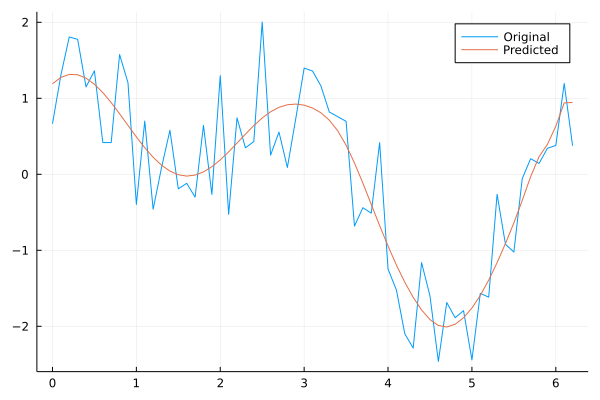

In [47]:
plot(xs, ys, label="Original")
plot!(xs, ex.(xs), label="Predicted")

You can find the corresponding Jupyter notebook in the [Evolutionary](https://github.com/wildart/Evolutionary.jl/tree/master/examples) package repository.